### 🔄 Stock Price Retrieval and Preprocessing

We start by retrieving historical stock price data using the `yfinance` library. The closing prices are normalized to a range of [0, 1] using **Min-Max Scaling** to stabilize training.

We also convert the time series into overlapping input sequences for model training.

- **Function**: `get_stock_data(ticker, start, end)`
- **Preprocessing**:
  - Use `MinMaxScaler` to normalize.
  - Use `create_sequences(data, seq_length)` to generate sliding windows of time steps.

Let \( P = [p_1, p_2, ..., p_n] \) be the raw prices. Then scaled prices are computed as:

\[
P_{\text{scaled}} = \frac{P - P_{\min}}{P_{\max} - P_{\min}}
\]

This helps LSTM models converge faster and reduces numerical instability.

### 🧪 Generator Network (LSTM)

The **Generator** uses a stacked LSTM to learn and generate synthetic sequences of stock prices from random noise. 

#### Architecture:
- **Input**: Random noise of shape \((\text{batch\_size}, \text{seq\_len}, 1)\)
- **LSTM**: 2 layers, 128 hidden units, dropout = 0.3
- **Output**: Same shape as input (price sequence)

#### Forward Pass:
\[
\text{noise} \xrightarrow{\text{LSTM}} \text{hidden state} \xrightarrow{\text{FC}} \text{synthetic sequence}
\]

The LSTM learns temporal dependencies and emits outputs at each time step.

### 🚫 Discriminator Network (Bidirectional LSTM)

The **Discriminator** evaluates whether a given sequence is real (from historical data) or fake (from the Generator).

#### Architecture:
- **Input**: Sequence of shape \((\text{batch\_size}, \text{seq\_len}, 1)\)
- **LSTM**: Bidirectional, 2 layers, 128 hidden units
- **FC + Sigmoid**: Outputs a binary classification score

#### Mechanism:
\[
\text{sequence} \xrightarrow{\text{BiLSTM}} h \xrightarrow{\text{FC}} \hat{y} \in [0, 1]
\]

The Discriminator aims to output 1 for real and 0 for fake sequences.


*********************100%***********************]  1 of 1 completed

Shape of input sequences: (1228, 30, 1)
Epoch [25/300], D Loss: 0.9640, G Loss: 0.9778
Epoch [50/300], D Loss: 1.0652, G Loss: 0.9951
Epoch [75/300], D Loss: 1.0334, G Loss: 1.0322
Epoch [100/300], D Loss: 1.0080, G Loss: 1.1622
Epoch [125/300], D Loss: 1.1460, G Loss: 1.0085
Epoch [150/300], D Loss: 1.0675, G Loss: 1.1404
Epoch [175/300], D Loss: 0.9924, G Loss: 1.0842
Epoch [200/300], D Loss: 0.9951, G Loss: 1.1381
Epoch [225/300], D Loss: 1.2167, G Loss: 1.0003
Epoch [250/300], D Loss: 1.3790, G Loss: 0.7290
Epoch [275/300], D Loss: 1.3605, G Loss: 0.7865
Epoch [300/300], D Loss: 1.3395, G Loss: 0.6868


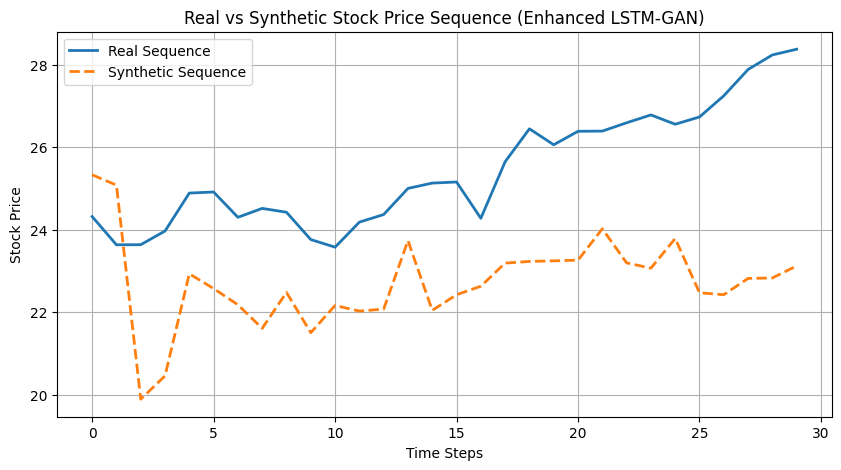

In [4]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# -------------------------------
# Load and preprocess data
# -------------------------------
def get_stock_data(ticker='AAPL', start='2015-01-01', end='2020-01-01'):
    df = yf.download(ticker, start=start, end=end)
    prices = df['Close'].values.reshape(-1, 1)
    scaler = MinMaxScaler()
    scaled_prices = scaler.fit_transform(prices)
    return scaled_prices, scaler

def create_sequences(data, seq_length):
    X = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
    return np.array(X)

# -------------------------------
# More powerful Generator
# -------------------------------
class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2):
        super(Generator, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out)
        return out

# -------------------------------
# More powerful Discriminator
# -------------------------------
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=2):
        super(Discriminator, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers,
                            batch_first=True, bidirectional=True, dropout=0.3)
        self.fc = nn.Linear(hidden_dim * 2, 1)  # ×2 for bidirectional
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # use the last time step
        return self.sigmoid(out)

# -------------------------------
# Training Loop
# -------------------------------
def train_gan(real_data, seq_length=30, num_epochs=300, batch_size=32):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    gen = Generator(1, 128, 1).to(device)
    disc = Discriminator(1, 128).to(device)

    criterion = nn.BCELoss()
    optimizer_g = torch.optim.Adam(gen.parameters(), lr=0.0002)
    optimizer_d = torch.optim.Adam(disc.parameters(), lr=0.0002)

    for epoch in range(num_epochs):
        perm = np.random.permutation(real_data.shape[0])
        real_data = real_data[perm]

        for i in range(0, len(real_data), batch_size):
            real_seq = real_data[i:i+batch_size]
            if len(real_seq) != batch_size:
                continue
            real_seq = torch.tensor(real_seq, dtype=torch.float32).to(device)

            # Generate fake sequences
            noise = torch.randn((batch_size, seq_length, 1)).to(device)
            fake_seq = gen(noise)

            # Discriminator Loss
            real_labels = torch.ones((batch_size, 1)).to(device)
            fake_labels = torch.zeros((batch_size, 1)).to(device)

            outputs_real = disc(real_seq)
            outputs_fake = disc(fake_seq.detach())

            loss_real = criterion(outputs_real, real_labels)
            loss_fake = criterion(outputs_fake, fake_labels)
            loss_d = loss_real + loss_fake

            optimizer_d.zero_grad()
            loss_d.backward()
            optimizer_d.step()

            # Generator Loss
            outputs_fake = disc(fake_seq)
            loss_g = criterion(outputs_fake, real_labels)

            optimizer_g.zero_grad()
            loss_g.backward()
            optimizer_g.step()

        if (epoch + 1) % 25 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], D Loss: {loss_d.item():.4f}, G Loss: {loss_g.item():.4f}')

    return gen

# -------------------------------
# Run the model
# -------------------------------
seq_len = 30
data, scaler = get_stock_data('AAPL')
sequences = create_sequences(data, seq_len)

print("Shape of input sequences:", sequences.shape)

generator = train_gan(sequences, seq_length=seq_len)

# -------------------------------
# Generate and plot synthetic vs real data
# -------------------------------
real_example = sequences[0].squeeze()
real_prices = scaler.inverse_transform(real_example.reshape(-1, 1))

with torch.no_grad():
    noise = torch.randn((1, seq_len, 1)).to(next(generator.parameters()).device)
    fake_seq = generator(noise).cpu().squeeze().numpy()
    fake_prices = scaler.inverse_transform(fake_seq.reshape(-1, 1))

plt.figure(figsize=(10, 5))
plt.plot(real_prices, label="Real Sequence", linewidth=2)
plt.plot(fake_prices, label="Synthetic Sequence", linewidth=2, linestyle='--')
plt.title("Real vs Synthetic Stock Price Sequence (Enhanced LSTM-GAN)")
plt.xlabel("Time Steps")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.show()
